<a href="https://colab.research.google.com/github/jitbnerejee4/jit/blob/fastai/MNIST_KAGGLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.basics import *

In [0]:
class NumpyImageList(ImageList):
    def open(self, fn):
        img = fn.reshape(28,28,1)
        return Image(pil2tensor(img, dtype=np.float32))
    
    @classmethod
    def from_csv(cls, path:PathOrStr, csv:str, **kwargs)->'ItemList': 
        df = pd.read_csv(Path(path)/csv, header='infer')
        res = super().from_df(df, path=path, cols=0, **kwargs)

        if 'label' in df.columns:
            df = df.drop('label', axis=1)
        df = np.array(df)/255.
        res.items = (df-df.mean())/df.std()

        return res

In [0]:
path = Path('/content')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/content')

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [0]:
!kaggle competitions download -c digit-recognizer 

 82% 5.00M/6.09M [00:00<00:00, 22.3MB/s]
100% 6.09M/6.09M [00:00<00:00, 24.2MB/s]
 55% 5.00M/9.16M [00:00<00:00, 30.7MB/s]
100% 9.16M/9.16M [00:00<00:00, 44.8MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 102MB/s]


In [0]:
test = NumpyImageList.from_csv(path, 'test.csv.zip')

In [0]:
test

NumpyImageList (28000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /content

In [0]:
train = NumpyImageList.from_csv(path, 'train.csv.zip')

In [0]:
train

NumpyImageList (42000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /content

In [0]:
sd = train.split_by_idx(list(range(10000)))

In [0]:
sd

ItemLists;

Train: NumpyImageList (32000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /content;

Valid: NumpyImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /content;

Test: None

In [0]:
la = sd.label_from_df(cols='label')

In [0]:
la

LabelLists;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: None

In [0]:
x,y = la.valid[0]

1 torch.Size([1, 28, 28])


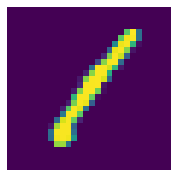

In [0]:
x.show()
print(y,x.shape)

In [0]:
la.add_test(test)

LabelLists;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [0]:
la = la.transform(tfms)

In [0]:
bs = 128

In [0]:
data = la.databunch(bs=bs).normalize()

In [0]:
x,y = data.train_ds[0]

2


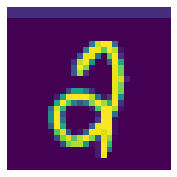

In [0]:
x.show()
print(y)

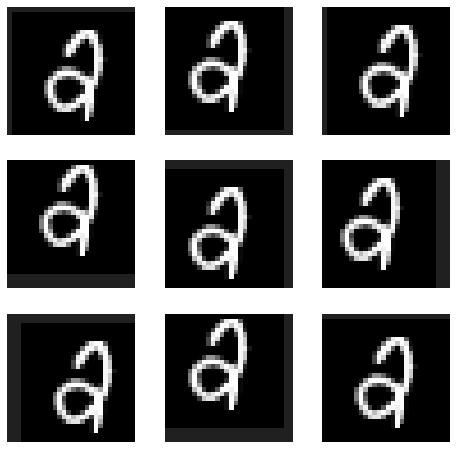

In [0]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

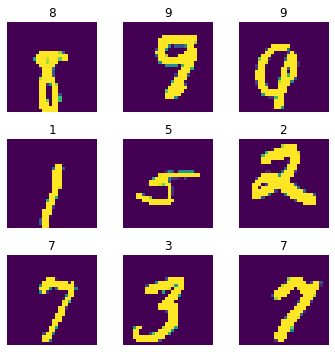

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [0]:
dropout = 0.25
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,
                 stride=2),
    nn.Dropout(dropout),

    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,
                 stride=2),
    nn.Dropout(dropout),

    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),

      conv(32, 64), # 4
    nn.BatchNorm2d(64),
    nn.ReLU(),

      conv(64, 128), # 4
    nn.BatchNorm2d(128),
    nn.ReLU(),

      conv(128, 64), # 4
    nn.BatchNorm2d(64),
    nn.ReLU(),

     conv(64, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),

    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),

    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
MaxPool2d            [8, 7, 7]            0          False     
______________________________________________________________________
Dropout              [8, 7, 7]            0          False     
______________________________________________________________________
Conv2d               [16, 4, 4]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 4, 4]           32         True      
___________________________________________________

In [0]:
xb = xb.cuda()

In [0]:
model(xb).shape

torch.Size([128, 10])

In [0]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


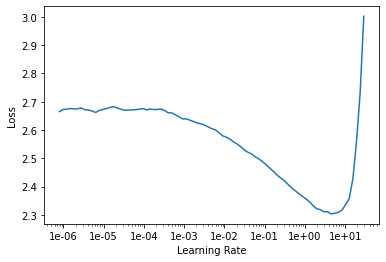

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,1.269325,0.674218,0.772600,00:06
1,1.000117,0.642163,0.800300,00:06
2,0.852153,0.333998,0.908600,00:06
3,0.705818,0.245676,0.934000,00:06
4,0.634040,0.220162,0.940300,00:06


In [0]:
learn.save('stage-1')

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


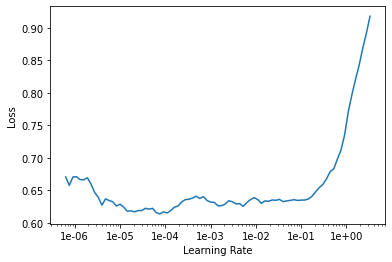

In [0]:
learn.recorder.plot()

In [0]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.25, inplace=False)
  (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, 

In [0]:
learn.fit_one_cycle(5, max_lr=1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.630383,0.218663,0.941800,00:07
1,0.612598,0.210828,0.943500,00:07
2,0.626567,0.210892,0.943100,00:07
3,0.603154,0.212875,0.943200,00:07
4,0.601401,0.209764,0.943200,00:07


In [0]:
learn.save('stage-2')

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


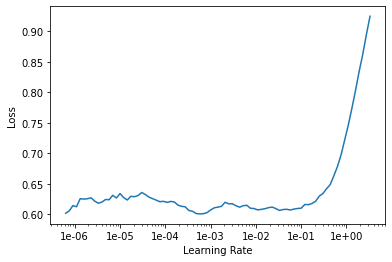

In [0]:
learn.recorder.plot()

In [0]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.25, inplace=False)
  (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, 

In [0]:
learn.fit_one_cycle(5, max_lr=1e-05)

epoch,train_loss,valid_loss,accuracy,time
0,0.599327,0.209762,0.943400,00:07
1,0.599199,0.213993,0.941700,00:07
2,0.611420,0.211790,0.943600,00:07
3,0.600501,0.209847,0.942500,00:07
4,0.609190,0.211457,0.943700,00:07


In [0]:
learn.save('stage-3')

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


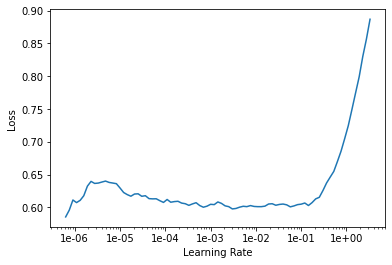

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20, max_lr=1e-06)

epoch,train_loss,valid_loss,accuracy,time
0,0.608869,0.212169,0.943700,00:07
1,0.607826,0.208699,0.942400,00:07
2,0.608004,0.206834,0.943400,00:07
3,0.613217,0.208832,0.944500,00:07
4,0.613797,0.209959,0.941700,00:07
5,0.594272,0.212591,0.943600,00:07
6,0.626417,0.211723,0.942100,00:07
7,0.604263,0.213143,0.942200,00:07
8,0.607469,0.213086,0.941800,00:07
9,0.603370,0.210497,0.943600,00:06


In [0]:
learn.load('stage-3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.25, inplace=False)
  (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, 

In [0]:
learn.fit_one_cycle(5,1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.615108,0.212208,0.942500,00:06
1,0.595199,0.211683,0.941400,00:06
2,0.627896,0.205257,0.943500,00:06
3,0.611187,0.209764,0.942900,00:06
4,0.608391,0.208727,0.944300,00:06


In [0]:
learn.fit_one_cycle(5, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.734816,0.491249,0.854500,00:06
1,0.794850,0.325476,0.911200,00:06
2,0.716684,0.300743,0.923300,00:06
3,0.599491,0.199294,0.944700,00:06
4,0.571479,0.182517,0.946900,00:06


In [0]:
learn.save('stage-4')

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


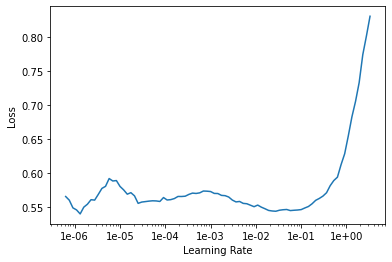

In [0]:
learn.recorder.plot()

In [0]:
learn.load('stage-4')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.25, inplace=False)
  (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, 

In [0]:
learn.fit_one_cycle(20, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.559155,0.188876,0.948900,00:06
1,0.591170,0.228048,0.931500,00:06
2,0.637919,0.248801,0.930900,00:06
3,0.666332,0.279580,0.914200,00:06
4,0.698343,0.323119,0.915600,00:06
5,0.694168,0.481480,0.853100,00:06
6,0.683941,0.425021,0.856700,00:06
7,0.679048,0.334471,0.899400,00:06
8,0.650654,0.350902,0.896900,00:06
9,0.621367,0.240036,0.932700,00:06


In [0]:
learn.save('stage-5')

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


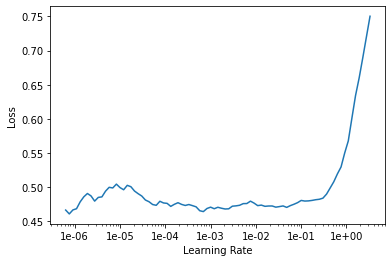

In [0]:
learn.recorder.plot()

In [0]:
learn.load('stage-5')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.25, inplace=False)
  (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, 

In [0]:
learn.fit_one_cycle(30, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.457233,0.148055,0.956000,00:06
1,0.476056,0.154021,0.954800,00:06
2,0.497037,0.167993,0.951600,00:06
3,0.531029,0.211314,0.938700,00:06
4,0.584689,0.289409,0.916200,00:06
5,0.606321,0.342804,0.893700,00:06
6,0.626310,0.286965,0.912900,00:06
7,0.641965,0.257951,0.927200,00:06
8,0.647228,0.245277,0.922200,00:06
9,0.636202,0.319536,0.906500,00:06


In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


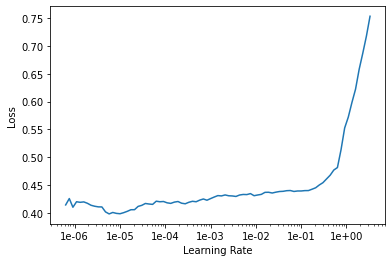

In [0]:
learn.recorder.plot()

In [0]:
learn.load('stage-5')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.25, inplace=False)
  (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, 

In [0]:
learn.fit_one_cycle(20, max_lr=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.462986,0.144637,0.957300,00:07
1,0.454231,0.145075,0.957500,00:07
2,0.466759,0.144600,0.957400,00:06
3,0.456978,0.145488,0.957500,00:06
4,0.452659,0.145529,0.956100,00:06
5,0.459123,0.145914,0.956500,00:06
6,0.459451,0.144122,0.957600,00:07
7,0.462542,0.147973,0.955800,00:07
8,0.453861,0.144821,0.957000,00:06
9,0.465771,0.145528,0.956700,00:06


In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


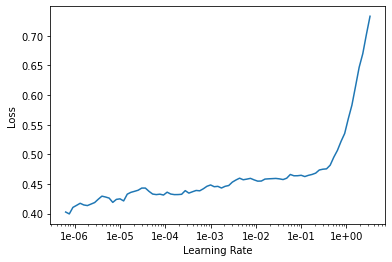

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, 1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.463094,0.143835,0.957400,00:07
1,0.454413,0.145140,0.957000,00:07
2,0.464599,0.146194,0.957400,00:07
3,0.452455,0.145361,0.956700,00:06
4,0.460566,0.148105,0.956400,00:06
5,0.464358,0.146592,0.957100,00:06
6,0.448433,0.144856,0.956600,00:07
7,0.454052,0.148079,0.956900,00:07
8,0.455729,0.144505,0.957500,00:07
9,0.447215,0.145858,0.957000,00:06


REFACTOR

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn2 = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
learn2.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.387618,0.264880,0.919400,00:06
1,0.246033,0.210531,0.937100,00:06
2,0.205495,0.289264,0.913300,00:06
3,0.178924,0.146622,0.953600,00:06
4,0.142835,0.347065,0.897500,00:06
5,0.127897,0.089714,0.972200,00:06
6,0.102827,0.069101,0.979000,00:06
7,0.081843,0.053248,0.982800,00:06
8,0.069211,0.043734,0.986700,00:06
9,0.059119,0.042242,0.986100,00:06


In [0]:
learn2.save('stage-1-l2')

In [0]:
learn2.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


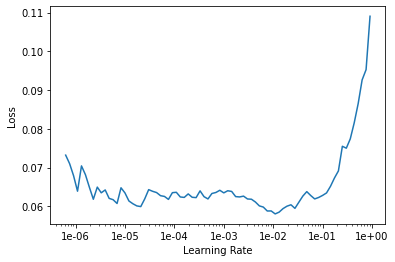

In [0]:
learn2.recorder.plot()

In [0]:
learn2.load('stage-1-l2')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affi

In [0]:
learn2.fit_one_cycle(10, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.062041,0.042028,0.987300,00:06
1,0.059795,0.041320,0.987100,00:05
2,0.060623,0.041872,0.987100,00:06
3,0.055302,0.041400,0.987500,00:06
4,0.057689,0.041237,0.987400,00:05
5,0.057266,0.040697,0.987200,00:05
6,0.057371,0.041105,0.987200,00:05
7,0.060732,0.041440,0.987300,00:05
8,0.052219,0.040815,0.986800,00:05
9,0.060058,0.040707,0.986900,00:05


In [0]:
learn2.save('stage-2-l2')

In [0]:
learn2.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


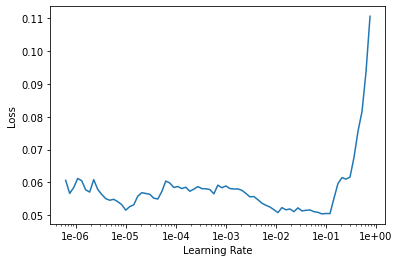

In [0]:
learn2.recorder.plot()

In [0]:
learn2.load('stage-2-l2')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affi

In [0]:
learn2.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.059252,0.041173,0.987100,00:06
1,0.057406,0.043450,0.986700,00:05
2,0.066756,0.039047,0.987300,00:05
3,0.062684,0.040491,0.988700,00:06
4,0.058641,0.041008,0.987700,00:06
5,0.056717,0.039357,0.987800,00:06
6,0.047214,0.037716,0.987700,00:05
7,0.056422,0.033753,0.989600,00:05
8,0.053460,0.033401,0.990300,00:05
9,0.048698,0.033023,0.990100,00:05


In [0]:
learn2.save('stage-3-l2')

In [0]:
predictions, *_ = learn2.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
# output to a file
submission_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
submission_df.to_csv(f'submission.csv', index=False)

RESNET

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:

def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()

)

In [0]:
learn3 = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


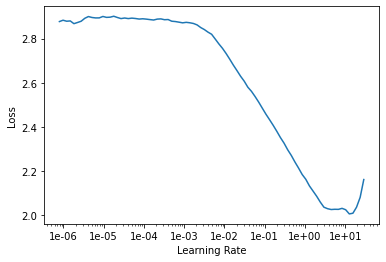

In [0]:
learn3.lr_find(end_lr=100)
learn3.recorder.plot()

In [0]:
learn3.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.372710,0.210185,0.941100,00:07
1,0.170523,0.144760,0.955600,00:07
2,0.147029,0.252233,0.921700,00:07
3,0.116002,0.169608,0.950900,00:07
4,0.095357,0.096665,0.971200,00:07
5,0.079987,0.061423,0.982000,00:07
6,0.068336,0.142069,0.949500,00:07
7,0.056424,0.039499,0.986100,00:07
8,0.039143,0.039753,0.988400,00:07
9,0.032379,0.031363,0.990100,00:07


In [0]:
learn3.save('stage-1-l3')

In [0]:
learn3.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


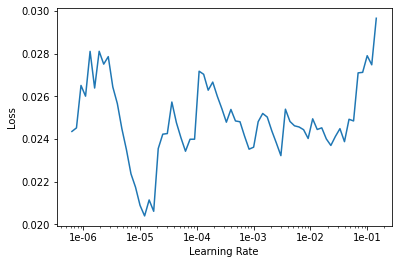

In [0]:
learn3.recorder.plot()

In [0]:
learn3.load('stage-1-l3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [0]:
learn3.fit_one_cycle(12, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.022636,0.026069,0.991900,00:07
1,0.023823,0.028341,0.990600,00:07
2,0.027126,0.041219,0.987200,00:07
3,0.031981,0.037202,0.988600,00:07
4,0.029797,0.038216,0.987900,00:07
5,0.026790,0.031707,0.990700,00:07
6,0.025471,0.025983,0.991200,00:07
7,0.022540,0.028062,0.991000,00:07
8,0.015896,0.024559,0.991500,00:07
9,0.018074,0.025534,0.991000,00:07


In [0]:
learn3.save('stage-2-l3')

In [0]:
learn3.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


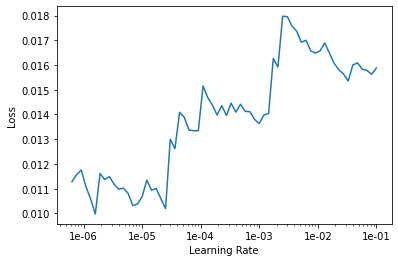

In [0]:
learn3.recorder.plot()

In [0]:
learn3.load('stage-2-l3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [0]:
learn3.fit_one_cycle(12, max_lr=1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.013070,0.022651,0.992800,00:07
1,0.012677,0.023227,0.992300,00:07
2,0.015641,0.023683,0.992100,00:07
3,0.013682,0.021909,0.992500,00:07
4,0.013267,0.022079,0.992900,00:07
5,0.015810,0.023035,0.992800,00:07
6,0.013488,0.022806,0.992300,00:07
7,0.013291,0.021785,0.992800,00:07
8,0.014477,0.022023,0.992900,00:07
9,0.011276,0.022786,0.993200,00:07


In [0]:
learn3.save('stage-3-l3')

In [0]:
learn3.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


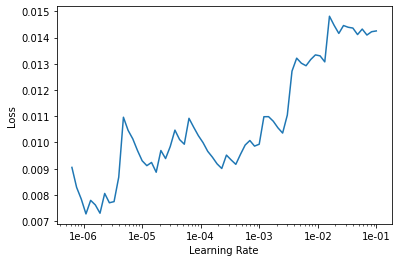

In [0]:
learn3.recorder.plot()

In [0]:
learn3.load('stage-3-l3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [0]:
learn3.fit_one_cycle(12, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.011187,0.022739,0.993400,00:07
1,0.017643,0.028533,0.991100,00:07
2,0.024909,0.032207,0.989600,00:07
3,0.025207,0.031347,0.990300,00:07
4,0.025096,0.035964,0.988900,00:07
5,0.021218,0.028760,0.991300,00:07
6,0.023120,0.026156,0.991300,00:07
7,0.016900,0.026371,0.991900,00:07
8,0.016423,0.022326,0.993600,00:07
9,0.013053,0.021582,0.993400,00:07


In [0]:
learn3.save('stage-4-l3')

In [0]:
learn3.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


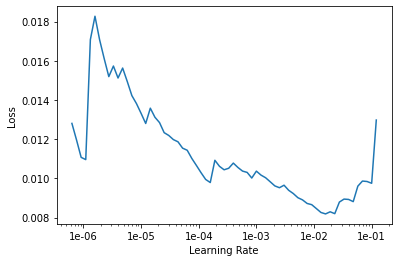

In [0]:
learn3.recorder.plot()

In [0]:
learn3.load('stage-4-l3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [0]:
learn3.fit_one_cycle(12, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.008643,0.021366,0.993200,00:07
1,0.017842,0.024291,0.992600,00:07
2,0.026319,0.033546,0.989500,00:07
3,0.026168,0.055152,0.984300,00:07
4,0.020704,0.027739,0.991300,00:07
5,0.023610,0.026184,0.991700,00:07
6,0.023148,0.028700,0.991500,00:07
7,0.018754,0.028661,0.991500,00:07
8,0.014784,0.023608,0.993300,00:07
9,0.010207,0.020625,0.993800,00:07


In [0]:
learn3.save('stage-5-l3')

In [0]:
learn3.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


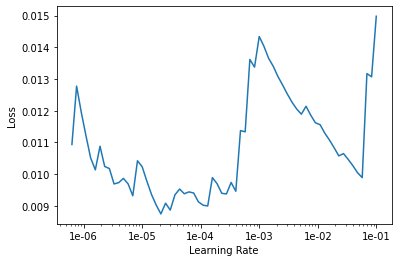

In [0]:
learn3.recorder.plot()

In [0]:
learn3.load('stage-5-l3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [0]:
learn3.fit_one_cycle(20, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.010094,0.022705,0.993000,00:07
1,0.011319,0.024084,0.992800,00:07
2,0.012189,0.034806,0.989700,00:07
3,0.017760,0.047501,0.986500,00:07
4,0.021776,0.034166,0.990300,00:07
5,0.022490,0.026896,0.991700,00:07
6,0.022354,0.029612,0.991700,00:07
7,0.028074,0.030740,0.992400,00:07
8,0.022346,0.032765,0.990100,00:07
9,0.024282,0.035703,0.988100,00:07


In [253]:
learn3.load('stage-5-l3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [254]:
learn3.fit_one_cycle(12, max_lr=1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,0.030249,0.052976,0.985400,00:07
1,0.079333,0.129537,0.962400,00:07
2,0.093040,0.144391,0.956200,00:07
3,0.097411,0.111922,0.967200,00:07
4,0.089632,0.204776,0.943300,00:07
5,0.076318,0.068578,0.979200,00:07
6,0.060482,0.122904,0.961700,00:07
7,0.053898,0.083095,0.977200,00:07
8,0.042513,0.041381,0.986400,00:07
9,0.029038,0.029751,0.989600,00:07


In [255]:
learn3.load('stage-5-l3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [256]:
learn3.fit_one_cycle(12, 1e-1/2.6**4)

epoch,train_loss,valid_loss,accuracy,time
0,0.008463,0.021710,0.993700,00:07
1,0.009814,0.023134,0.993100,00:07
2,0.010297,0.022508,0.993500,00:07
3,0.012119,0.021120,0.994400,00:07
4,0.010211,0.021627,0.994000,00:07
5,0.009730,0.022576,0.993700,00:07
6,0.009936,0.024223,0.993000,00:07
7,0.012460,0.023194,0.993400,00:07
8,0.010672,0.023167,0.993800,00:07
9,0.006374,0.023322,0.993600,00:07


In [0]:
learn3.save('stage-6-l3')

In [262]:
learn3.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


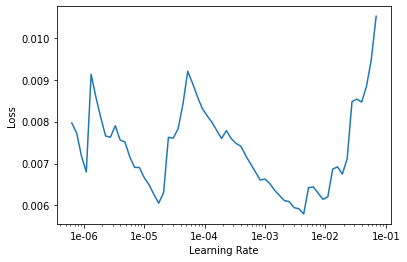

In [263]:
learn3.recorder.plot()

In [264]:
learn3.load('stage-6-l3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [265]:
learn3.fit_one_cycle(12, 1e-04/2.6**4)

epoch,train_loss,valid_loss,accuracy,time
0,0.007463,0.023568,0.994000,00:07
1,0.006850,0.024547,0.992800,00:07
2,0.007958,0.022953,0.993400,00:07
3,0.009316,0.023239,0.993400,00:07
4,0.009165,0.023442,0.993200,00:07
5,0.006913,0.023970,0.993500,00:07
6,0.009219,0.023119,0.993500,00:07
7,0.005879,0.023509,0.994000,00:07
8,0.006887,0.023293,0.993900,00:07
9,0.007601,0.023287,0.993700,00:07


In [266]:
learn3.load('stage-6-l3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [267]:
learn3.fit_one_cycle(12, 3e-3/2.6**4)

epoch,train_loss,valid_loss,accuracy,time
0,0.008637,0.023880,0.993200,00:07
1,0.005545,0.023070,0.993600,00:07
2,0.007554,0.022965,0.993700,00:07
3,0.008405,0.023316,0.993600,00:07
4,0.004707,0.023242,0.993500,00:07
5,0.008825,0.023220,0.993800,00:07
6,0.005434,0.023318,0.993500,00:07
7,0.009924,0.022946,0.993700,00:07
8,0.005745,0.023223,0.994000,00:07
9,0.008055,0.023289,0.993700,00:07


In [268]:
learn3.load('stage-6-l3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [269]:
learn3.fit_one_cycle(12, max_lr=1e-3/2.6**4)

epoch,train_loss,valid_loss,accuracy,time
0,0.007727,0.023421,0.993000,00:07
1,0.006522,0.023332,0.993200,00:07
2,0.008556,0.023778,0.993300,00:07
3,0.006444,0.024017,0.993300,00:07
4,0.007715,0.023111,0.993500,00:07
5,0.007922,0.024075,0.992900,00:07
6,0.007836,0.023243,0.993700,00:07
7,0.006003,0.022958,0.993600,00:07
8,0.007433,0.023362,0.993300,00:07
9,0.007370,0.023521,0.993500,00:07


In [270]:
learn3.load('stage-6-l3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [271]:
learn3.fit_one_cycle(12, max_lr=1e-1/2.6**4)

epoch,train_loss,valid_loss,accuracy,time
0,0.007030,0.023711,0.993300,00:07
1,0.007423,0.024297,0.992700,00:07
2,0.011090,0.024720,0.992900,00:07
3,0.008753,0.023945,0.993600,00:07
4,0.009302,0.023506,0.993100,00:07
5,0.009843,0.024573,0.993400,00:07
6,0.011020,0.025547,0.993100,00:07
7,0.008373,0.024529,0.993600,00:07
8,0.006296,0.023850,0.994000,00:07
9,0.006470,0.024274,0.993500,00:07


In [272]:
learn3.load('stage-6-l3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [273]:
learn3.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


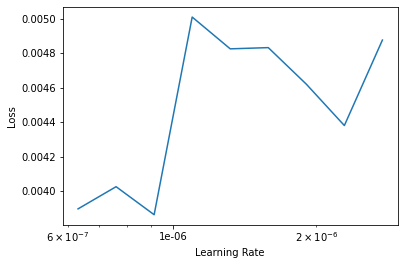

In [274]:
learn3.recorder.plot()

In [275]:
learn3.load('stage-6-l3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [276]:
learn3.fit_one_cycle(12, max_lr=1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.007730,0.023899,0.993300,00:07
1,0.006266,0.023335,0.993100,00:07
2,0.008495,0.023405,0.993400,00:07
3,0.005443,0.023904,0.993300,00:07
4,0.008225,0.024086,0.993300,00:07
5,0.006191,0.022546,0.993700,00:07
6,0.007134,0.022990,0.993600,00:07
7,0.007185,0.023555,0.992900,00:07
8,0.007185,0.023454,0.994000,00:07
9,0.007189,0.023032,0.993600,00:07


In [277]:
learn3.load('stage-6-l3')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [278]:
predictions, *_ = learn3.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
# output to a file
submission_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
submission_df.to_csv(f'submission5.csv', index=False)

CUSTOM RESNET

In [0]:
class ResBlock2(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        self.conv3 = conv_layer(nf,nf)
        self.conv4 = conv_layer(nf,nf)
        self.conv5 = conv_layer(nf,nf)
        self.conv6 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv6(self.conv5(x))

In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 64),
    res_block(64),
    conv2(64, 128),
    res_block(128),
    conv2(128, 64),
    res_block(64),
    conv2(64, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
def conv_and_res2(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 64),
    conv_and_res(64, 128),
    conv_and_res(128, 64),
    conv_and_res(64, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn4 = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [285]:
learn4.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


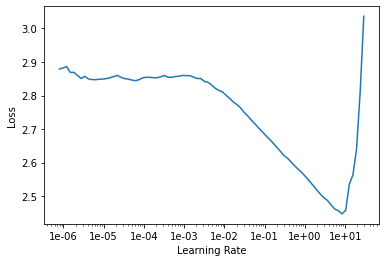

In [287]:
learn4.lr_find(end_lr=100)
learn4.recorder.plot()

In [288]:
learn4.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,1.024097,0.501443,0.853500,00:09
1,0.313733,0.579087,0.848700,00:10
2,0.223258,0.266961,0.931500,00:09
3,0.172291,0.288955,0.923400,00:09
4,0.135845,0.134239,0.963700,00:09
5,0.112497,0.369497,0.901900,00:09
6,0.081013,0.092010,0.974200,00:09
7,0.064567,0.060841,0.982600,00:09
8,0.048472,0.042811,0.985000,00:10
9,0.036851,0.037187,0.988600,00:10


In [0]:
learn4.save('stage-1-l4')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


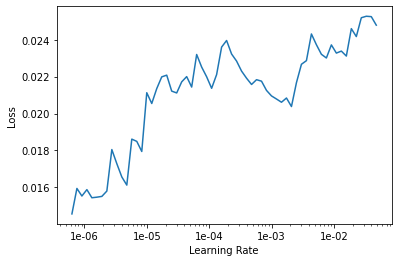

In [290]:
learn4.lr_find()
learn4.recorder.plot()

In [291]:
learn4.load('stage-1-l4')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [292]:
learn4.fit_one_cycle(12,max_lr=1e-04)

epoch,train_loss,valid_loss,accuracy,time
0,0.024327,0.026162,0.992000,00:10
1,0.024316,0.026743,0.991600,00:09
2,0.023802,0.025595,0.992300,00:10
3,0.025053,0.025248,0.992100,00:09
4,0.024730,0.026163,0.992000,00:10
5,0.020549,0.025433,0.991900,00:10
6,0.020060,0.026066,0.992000,00:09
7,0.023214,0.025804,0.992000,00:09
8,0.023888,0.025369,0.992200,00:10
9,0.021784,0.025368,0.992000,00:09


In [0]:
learn4.save('stage-2-l4')

In [295]:
learn4.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


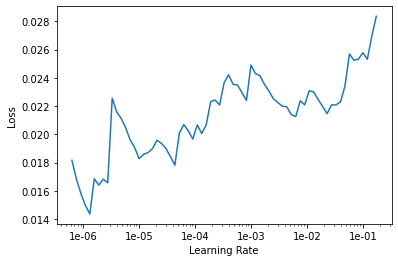

In [296]:
learn4.recorder.plot()

In [298]:
learn4.load('stage-2-l4')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [299]:
learn4.fit_one_cycle(12, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.023158,0.025681,0.992100,00:09
1,0.024633,0.026019,0.992000,00:09
2,0.022654,0.025564,0.992400,00:09
3,0.021996,0.024987,0.992500,00:09
4,0.022728,0.025132,0.992600,00:10
5,0.022596,0.025004,0.992100,00:10
6,0.021446,0.024691,0.992600,00:09
7,0.022000,0.024851,0.992800,00:09
8,0.019191,0.024088,0.993000,00:09
9,0.019342,0.024253,0.993000,00:09


In [0]:
learn4.save('stage-3-l4')

In [308]:
learn4.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


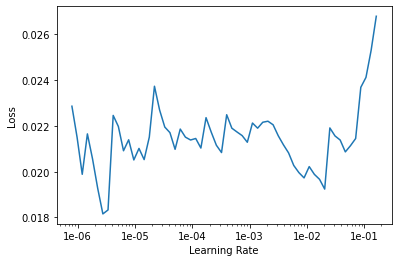

In [309]:
learn4.recorder.plot()

In [310]:
learn4.load('stage-3-l4')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [311]:
learn4.fit_one_cycle(12, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.021613,0.024327,0.992800,00:09
1,0.024283,0.029813,0.991500,00:09
2,0.028841,0.036642,0.989500,00:09
3,0.034252,0.035737,0.988800,00:09
4,0.032753,0.028720,0.991800,00:09
5,0.034140,0.028701,0.991100,00:09
6,0.024139,0.026014,0.992100,00:09
7,0.022061,0.029855,0.991700,00:09
8,0.018029,0.022489,0.993400,00:09
9,0.015437,0.023813,0.993200,00:09


In [0]:
learn4.save('stage-4-l4')

In [316]:
learn4.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


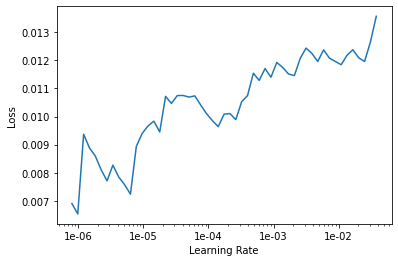

In [317]:
learn4.recorder.plot()

In [323]:
learn4.load('stage-4-l4')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [324]:
learn4.fit_one_cycle(12, max_lr=1e-1/2.6**4)

epoch,train_loss,valid_loss,accuracy,time
0,0.013498,0.021508,0.993800,00:09
1,0.013859,0.021700,0.994300,00:09
2,0.013515,0.022641,0.993500,00:09
3,0.015142,0.022447,0.994500,00:09
4,0.011848,0.021926,0.993800,00:09
5,0.014001,0.023276,0.993500,00:09
6,0.014031,0.021770,0.993900,00:09
7,0.010348,0.022760,0.993600,00:10
8,0.013056,0.021493,0.993700,00:09
9,0.010190,0.022051,0.993700,00:09


In [0]:
learn4.save('stage-5-l4')

In [328]:
learn4.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


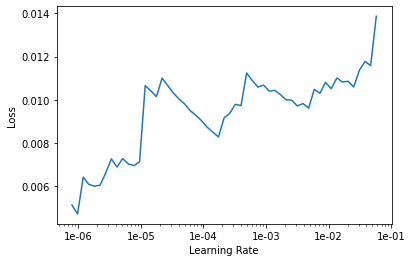

In [329]:
learn4.recorder.plot()

In [335]:
learn4.load('stage-5-l4')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [336]:
learn4.fit_one_cycle(1, max_lr=1e-2/2.6**4)

epoch,train_loss,valid_loss,accuracy,time
0,0.008862,0.021594,0.994500,00:09


In [0]:
learn4.save('stage-6-l4')

In [339]:
learn4.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


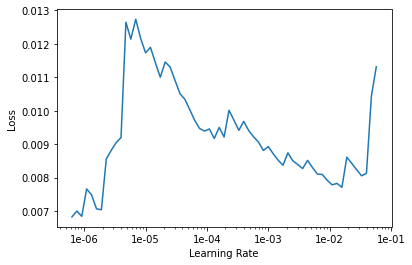

In [340]:
learn4.recorder.plot()

In [341]:
learn4.load('stage-6-l4')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [342]:
learn4.fit_one_cycle(3, max_lr=1e-3/2.6**4)

epoch,train_loss,valid_loss,accuracy,time
0,0.009810,0.021796,0.994500,00:09
1,0.007465,0.021525,0.994400,00:09
2,0.009180,0.021344,0.994700,00:09


In [0]:
learn4.save('stage-7-l4')

In [348]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


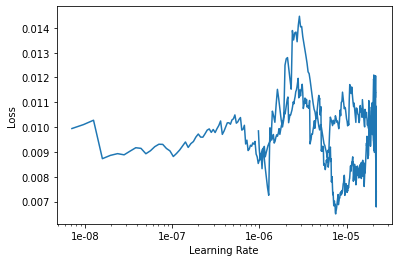

In [349]:
learn4.recorder.plot()

In [374]:
learn4.load('stage-7-l4')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [375]:
learn4.fit_one_cycle(12, 1e-3/3.6**4)

epoch,train_loss,valid_loss,accuracy,time
0,0.010396,0.021544,0.994400,00:09
1,0.008427,0.021226,0.994500,00:09
2,0.008543,0.021535,0.994400,00:09
3,0.008710,0.021243,0.994500,00:09
4,0.009165,0.021372,0.994300,00:09
5,0.009838,0.021332,0.994400,00:09
6,0.009109,0.021412,0.994600,00:09
7,0.008594,0.021427,0.994300,00:09
8,0.010079,0.021492,0.994400,00:09
9,0.011241,0.021391,0.994300,00:09


In [0]:
learn4.save('stage-8-l4')

In [381]:
learn4.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


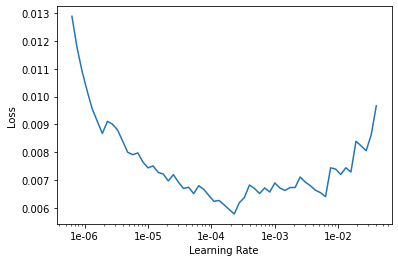

In [382]:
learn4.recorder.plot()

In [399]:
learn4.load('stage-8-l4')

Learner(data=ImageDataBunch;

Train: LabelList (32000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,5,9,9,3
Path: /content;

Valid: LabelList (10000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /content;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: /content, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [402]:
learn4.fit_one_cycle(12, 1e-2/3.6**4)

epoch,train_loss,valid_loss,accuracy,time
0,0.006059,3.101520,0.993000,00:09
1,0.006725,0.021811,0.994200,00:09
2,0.004870,0.022062,0.993900,00:09
3,0.007706,0.021786,0.994400,00:09
4,0.006650,0.052955,0.994000,00:09
5,0.008576,0.021752,0.994400,00:09
6,0.006641,0.022015,0.994400,00:09
7,0.005790,0.021726,0.994500,00:09
8,0.005505,0.335430,0.994300,00:09
9,0.005528,0.021914,0.994500,00:09
